# Financial Statements Classification - Data Preprocessing

This notebook preprocesses the financial statement pages for training three different computer vision models:

1. **ResNet50**
2. **EfficientNet-B2**  
3. **Vision Transformer (ViT-Base)**

### Dataset Statistics:
- Total pages: **1,179**
- 5 Target Classes:
  - Independent Auditor's Report: 111 **(9.4%)**
  - Financial Sheets: 124 **(10.5%)**
  - Notes (Tabular): 557 **(47.2%)**
  - Notes (Text): 321 **(27.2%)**
  - Other Pages: 66 **(5.6%)**

## Pipeline:
1. Load labeled data
2. Train/val/test split (stratified)
3. Define transforms for each model
4. Compute class weights for imbalance
5. Save everything for training

---
# Installing Packages & Importing Libraries

In [1]:
# Install if needed
!pip install -q torch torchvision timm albumentations

In [2]:
import os
import json
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

print(f"PyTorch: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

PyTorch: 2.9.0+cpu
Device: cpu


---
# Configurations

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DATA_PATH = '/content/drive/MyDrive/Sukuk AI Assessment/FinancialStatements'
LABELS_FILE = os.path.join(DATA_PATH, 'labels.csv')

OUTPUT_DIR = "/content/drive/MyDrive/Sukuk AI Assessment/FS_Classification"
IMAGES_DIR = os.path.join(OUTPUT_DIR, "images")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Settings
CONFIG = {
    'seed': 42,
    'test_size': 0.15,
    'val_size': 0.15,
    'batch_size': 16,
    'num_classes': 5,
}

# Set seed
np.random.seed(CONFIG['seed'])
torch.manual_seed(CONFIG['seed'])

---
# Loading Labels

We already have our labels that we created using DataLabeling.ipynb, now we need to encode it

In [5]:
# Load labels
labels_df = pd.read_csv(LABELS_FILE)
if 'notes' in labels_df.columns:
    labels_df = labels_df.drop(columns=['notes'])

# Encode labels
label_encoding = {
    'Independent Auditor\'s Report': 0,
    'Financial Sheets': 1,
    'Notes (Tabular)': 2,
    'Notes (Text)': 3,
    'Other Pages': 4
}

labels_df['label_encoded'] = labels_df['label'].map(label_encoding)

# Add full image paths
labels_df['image_path'] = labels_df['image_filename'].apply(
    lambda x: os.path.join(IMAGES_DIR, x)
)

# Class names
CLASS_NAMES = sorted(label_encoding, key=label_encoding.get)

print(f"Total images: {len(labels_df)}")
print(f"\nClass distribution:")
for i, name in enumerate(CLASS_NAMES):
    count = (labels_df['label_encoded'] == i).sum()
    print(f"  {i}: {name}: {count} ({count/len(labels_df)*100:.1f}%)")

Total images: 1179

Class distribution:
  0: Independent Auditor's Report: 111 (9.4%)
  1: Financial Sheets: 124 (10.5%)
  2: Notes (Tabular): 557 (47.2%)
  3: Notes (Text): 321 (27.2%)
  4: Other Pages: 66 (5.6%)


---
# Train/Val/Test Split (Stratified)

The data is not balanced, and to ensure a fair split between train/val/test tests, we apply a stratified strategy, and split the data into 70/15/15, then save those splits to use in upcoming training processes

In [10]:
# First split: train+val vs test
train_val_df, test_df = train_test_split(
    labels_df,
    test_size=CONFIG['test_size'],
    stratify=labels_df['label_encoded'],
    random_state=CONFIG['seed']
)

# Second split: train vs val
val_size_adjusted = CONFIG['val_size'] / (1 - CONFIG['test_size'])
train_df, val_df = train_test_split(
    train_val_df,
    test_size=val_size_adjusted,
    stratify=train_val_df['label_encoded'],
    random_state=CONFIG['seed']
)

# Reset indices
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("Splits Distributions:")
print(f"Train: {len(train_df)} ({len(train_df)/len(labels_df)*100:.1f}%)")
print(f"Val:   {len(val_df)} ({len(val_df)/len(labels_df)*100:.1f}%)")
print(f"Test:  {len(test_df)} ({len(test_df)/len(labels_df)*100:.1f}%)")

Splits Distributions:
Train: 825 (70.0%)
Val:   177 (15.0%)
Test:  177 (15.0%)


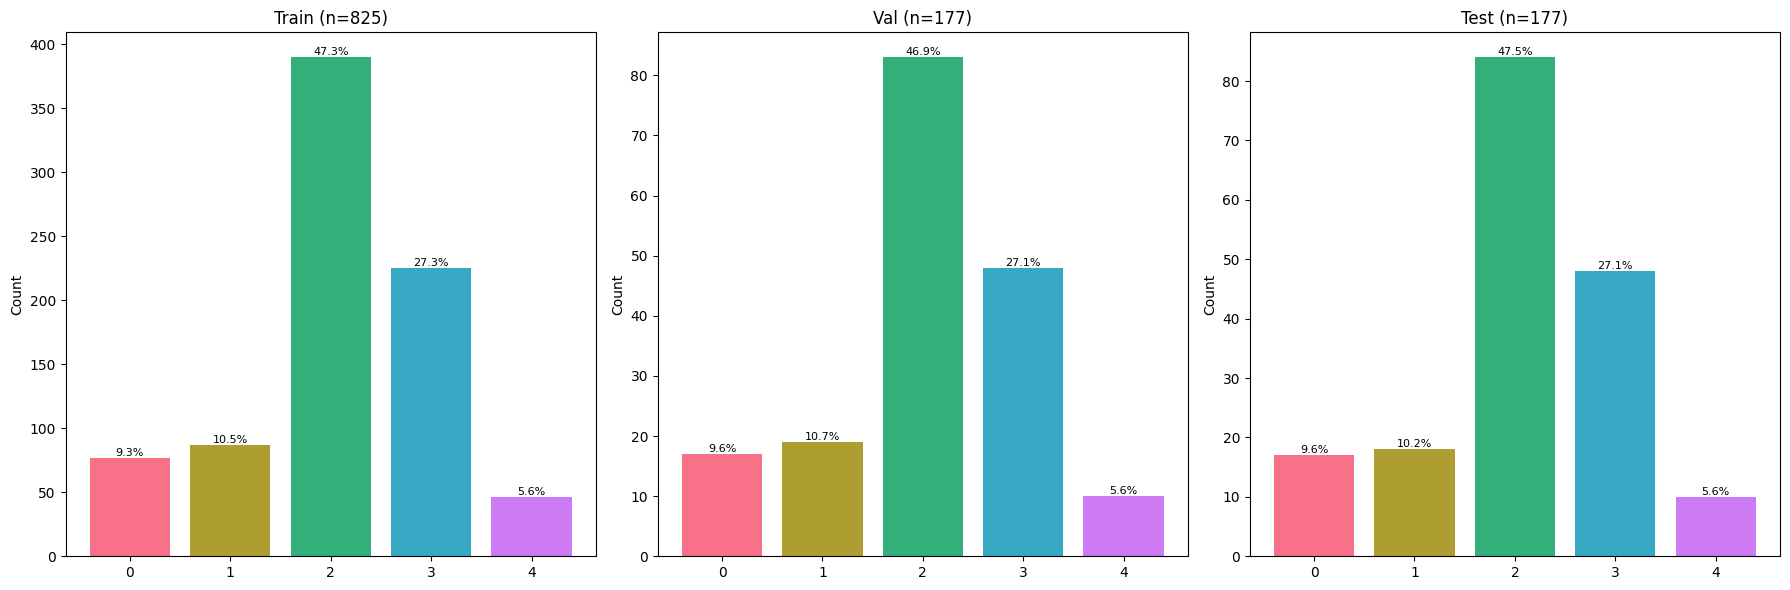

In [11]:
# Visualize distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for ax, (name, df) in zip(axes, [('Train', train_df), ('Val', val_df), ('Test', test_df)]):
    counts = df['label_encoded'].value_counts().sort_index()
    bars = ax.bar(range(len(counts)), counts.values, color=sns.color_palette('husl', 5))
    ax.set_xticks(range(5))
    ax.set_xticklabels(range(5))
    ax.set_title(f'{name} (n={len(df)})')
    ax.set_ylabel('Count')

    total_samples_in_split = len(df)
    for bar in bars:
        height = bar.get_height()
        percentage = (height / total_samples_in_split) * 100
        ax.text(bar.get_x() + bar.get_width() / 2,
                height, # Position the text above the bar
                f'{percentage:.1f}%',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [12]:
# Save
train_df.to_csv(os.path.join(OUTPUT_DIR, 'train.csv'), index=False)
val_df.to_csv(os.path.join(OUTPUT_DIR, 'val.csv'), index=False)
test_df.to_csv(os.path.join(OUTPUT_DIR, 'test.csv'), index=False)

---
# Model Configurations

Preparing and saving some configurations from now to make later setup processes easier, this includes getting ImageNet's mean and std values for all models we are going to use, as well as setting their each models' input size respectively

In [13]:
# ImageNet normalization (used by all models)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Model-specific configs
MODEL_CONFIGS = {
    'resnet50': {
        'input_size': 224,
        'timm_name': 'resnet50',
        'mean': IMAGENET_MEAN,
        'std': IMAGENET_STD,
    },

    'efficientnet_b2': {
        'input_size': 260,
        'timm_name': 'efficientnet_b2',
        'mean': IMAGENET_MEAN,
        'std': IMAGENET_STD,
    },

    'vit_base': {
        'input_size': 224,
        'timm_name': 'vit_base_patch16_224',
        'mean': IMAGENET_MEAN,
        'std': IMAGENET_STD,
    }
}

print("Model Configurations:")
for name, cfg in MODEL_CONFIGS.items():
    print(f"  {name}: {cfg['input_size']}x{cfg['input_size']}")

Model Configurations:
  resnet50: 224x224
  efficientnet_b2: 260x260
  vit_base: 224x224


---
# Compute Class Weights for the Loss Function

Since our classes are imbalanced, and to avoid any future biases to the majority classes (Notes (both tabular and text), we use inverse frequency to calcuate a weight for each class that is inversely proportional to its frequency, meaning it assigns higher values to classes with lower samples, and vice-versa

I mentioned its for the Loss Function because they will later on be passed to it to ensure the models pay more attention to the underrepresented classes

In [14]:
# Compute class weights using inverse frequency
class_counts = train_df['label_encoded'].value_counts().sort_index()
total_samples = len(train_df)
num_classes = CONFIG['num_classes']

# Inverse frequency weighting
weights = total_samples / (num_classes * class_counts.values)
weights = weights / weights.sum() * num_classes  # Normalize

class_weights = torch.FloatTensor(weights)

print("Class Weights for Loss Function:")
for i, (name, weight) in enumerate(zip(CLASS_NAMES, class_weights)):
    print(f"  {i}: {name:30s} → {weight:.4f}")

# Save
torch.save(class_weights, os.path.join(OUTPUT_DIR, 'class_weights.pt'))

Class Weights for Loss Function:
  0: Independent Auditor's Report   → 1.2199
  1: Financial Sheets               → 1.0797
  2: Notes (Tabular)                → 0.2409
  3: Notes (Text)                   → 0.4175
  4: Other Pages                    → 2.0420


---
# Save Configuration

Now we just save everything, and prepare for the next step: Model Training!

In [15]:
# Save all config info
config_dict = {
    'config': CONFIG,
    'model_configs': MODEL_CONFIGS,
    'class_names': CLASS_NAMES,
    'label_encoding': label_encoding,
    'imagenet_mean': IMAGENET_MEAN,
    'imagenet_std': IMAGENET_STD,
    'data_path': IMAGES_DIR,
    'splits': {
        'train_size': len(train_df),
        'val_size': len(val_df),
        'test_size': len(test_df),
    }
}

config_path = os.path.join(OUTPUT_DIR, 'config.json')
with open(config_path, 'w') as f:
    json.dump(config_dict, f, indent=2)